In [3]:
import tensorflow as tf
import numpy as np

In [4]:
# ! pip install demoji
# import demoji as demoji

In [5]:
!cat '/content/drive/My Drive/MasterThesis/Datasets/Offensive2020/trainDev/NOT_OFF/1000.txt'

@USER @USER ان شاء الله يا غالي حبيبي يا محمد<LF>ودايما متجمعين علي عشق الكيان	NOT_OFF	NOT_HS


In [6]:
batch_size = 32
raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    "/content/drive/My Drive/MasterThesis/Datasets/Offensive2020/trainDev",
    batch_size=batch_size,
    validation_split=0.2,
    subset="training",
    seed=1337,
   
)
raw_val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    "/content/drive/My Drive/MasterThesis/Datasets/Offensive2020/trainDev",
    batch_size=batch_size,
    validation_split=0.2,
    subset="validation",
    seed=1337,
    
)
raw_test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    "/content/drive/My Drive/MasterThesis/Datasets/Offensive2020/test", batch_size=batch_size
)

print(
    "Number of batches in raw_train_ds: %d"
    % tf.data.experimental.cardinality(raw_train_ds)
)
print(
    "Number of batches in raw_val_ds: %d" % tf.data.experimental.cardinality(raw_val_ds)
)
print(
    "Number of batches in raw_test_ds: %d"
    % tf.data.experimental.cardinality(raw_test_ds)
)

Found 8000 files belonging to 2 classes.
Using 6400 files for training.
Found 8000 files belonging to 2 classes.
Using 1600 files for validation.
Found 2000 files belonging to 2 classes.
Number of batches in raw_train_ds: 200
Number of batches in raw_val_ds: 50
Number of batches in raw_test_ds: 63


In [7]:
# It's important to take a look at your raw data to ensure your normalization
# and tokenization will work as expected. We can do that by taking a few
# examples from the training set and looking at them.
# This is one of the places where eager execution shines:
# we can just evaluate these tensors using .numpy()
# instead of needing to evaluate them in a Session/Graph context.
for text_batch, label_batch in raw_train_ds.take(1):
    for i in range(5):
        print(text_batch.numpy()[i].decode('utf-8').strip())
        print(label_batch.numpy()[i])
        print('--------------------------------')

RT @USER: يا رب يا عزيز يا جبار .. انك القادر على كل شيء .. يا رب فرحه اتحاديه تُنسينا كل الهموم والمشاكل الي صارت هالموسم يا رب العباد…	NOT_OFF	NOT_HS
0
--------------------------------
@USER @USER يا جامع يا رقيب يا رب تلقاها	NOT_OFF	NOT_HS
0
--------------------------------
راهنت عليك ولم اخسر ❤️❤️<LF>يا وحش يا جلاد يا كبير<LF>يا مرعب يا قناص يا يصياد<LF>🖤💛🖤💛🖤💛🖤💛<LF>#الاتحاد_النصر URL	NOT_OFF	NOT_HS
0
--------------------------------
RT @USER: كانت أيام يا وطني<LF>زي الأحلام يا وطني 🎶	NOT_OFF	NOT_HS
0
--------------------------------
تمثيل يا رزان تمثيل يا رزان تمثيل يا رزان تمثيل يا رزان تمثيل يا رزان تمثيل يا رزان	NOT_OFF	NOT_HS
0
--------------------------------


In [8]:
# demoji.download_codes()

In [ ]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
import string
import re
def custom_standardization(input_data):
    # lowercase = tf.strings.lower(input_data)
    # stripped_html = tf.strings.regex_replace(lowercase, "<LF>", " ")
    stripped_html = tf.strings.regex_replace(input_data, "[a-zA-Z]|\d+|[٠١٢٣٤٥٦٧٨٩]", " ")
    after_remove_punctuation = tf.strings.regex_replace(stripped_html, "[.،,!?؟\\-”“٪ًَ]", " ")
    
    after_remove_hamza = tf.strings.regex_replace(after_remove_punctuation, "[إأآا]", "ا")
    after_remove_Altaa = tf.strings.regex_replace(after_remove_hamza, "ة", "ه")
    after_remove_emoji=tf.strings.regex_replace(after_remove_Altaa, "[(\U0001F600-\U0001F92F|\U0001F300-\U0001F5FF|\U0001F680-\U0001F6FF|\U0001F190-\U0001F1FF|\U00002702-\U000027B0|\U0001F926-\U0001FA9F|\u200d|\u2640-\u2642|\u2600-\u2B55|\u23cf|\u23e9|\u231a|\ufe0f)|\u2069|\u2066]+", " ")
    after_remove_repeating_char = tf.strings.regex_replace(after_remove_emoji, "r'(.)\1+'", "r'\1\1'")

    return tf.strings.regex_replace(
       after_remove_repeating_char, "[%s]" % re.escape(string.punctuation), ""
    )
   
max_features = 20000
embedding_dim = 128
sequence_length = 500

vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode="int",
    output_sequence_length=sequence_length,
)

text_ds = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(text_ds)


In [ ]:
def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label


# Vectorize the data.
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

# Do async prefetching / buffering of the data for best performance on GPU.
# train_ds = train_ds.cache().prefetch(buffer_size=10)
# val_ds = val_ds.cache().prefetch(buffer_size=10)
# test_ds = test_ds.cache().prefetch(buffer_size=10)

In [ ]:
vocab = np.array(vectorize_layer.get_vocabulary())
vocab[4000:5000]

array(['يللا', 'يلعنكم', 'يلحق', 'يكونو', 'يكفيك', 'يكسب', 'يكبر',
       'يقولي', 'يفضح', 'يفرق', 'يغلط', 'يغفر', 'يعمل', 'يعلق', 'يعقوب',
       'يعطيك', 'يعد', 'يعجزه', 'يطالب', 'يصيح', 'يصل', 'يصدق', 'يصبح',
       'يشوفو', 'يشبه', 'يسالني', 'يرضيك', 'يرجع', 'يخرج', 'يحيي', 'يحيى',
       'يحميك', 'يحق', 'يحفظكم', 'يحفظ', 'يحضر', 'يحصل', 'يحدث', 'يحتاج',
       'يحب', 'يجيك', 'يجو', 'يتم', 'يتقبل', 'يتقال', 'يت', 'يبني',
       'يبكي', 'يانصف', 'يامهدي', 'ياللى', 'ياكلب', 'ياقدير', 'يافرد',
       'ياعشواء', 'ياض', 'ياسمين', 'ياخذكم', 'ياخديني', 'ياخدها',
       'ياحيُّ', 'ياحسن', 'ياحب', 'يابني', 'ياارب', 'يااااارب', 'يااا',
       'ويلكم', 'ويسعد', 'ويرحم', 'ويبارك', 'ووو', 'وهميين', 'وهذه',
       'وهاردلك', 'وهابي', 'وهاب', 'وه', 'ونور', 'ونقول', 'ونجومه', 'ون',
       'وميحرمنيش', 'ومهما', 'ومنها', 'ومفيش', 'ومرضى', 'ومحدش', 'وليبيا',
       'ولهانه', 'ولن', 'ولطفك', 'ولدهم', 'ولاحبتنا', 'وكُن', 'وكُل',
       'وكنت', 'وكن', 'وكرمك', 'وكده', 'وكان', 'وقولهم', 'وقول', 'وقلت',
 

In [ ]:
vectorize_layer

In [ ]:
encoded_example = vectorize_layer(text_batch)[:50].numpy()
encoded_example

array([[   2,    8,    2, ...,    0,    0,    0],
       [   2, 1641,    2, ...,    0,    0,    0],
       [   1,   19,  651, ...,    0,    0,    0],
       ...,
       [   2, 3321,    3, ...,    0,    0,    0],
       [   2,   90,    1, ...,    0,    0,    0],
       [   2,  309,  286, ...,    0,    0,    0]])

In [ ]:
for n in range(20):
  print("Original: ", text_batch[n].numpy().decode('utf-8').strip())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  RT @USER: يا رب يا عزيز يا جبار .. انك القادر على كل شيء .. يا رب فرحه اتحاديه تُنسينا كل الهموم والمشاكل الي صارت هالموسم يا رب العباد…	NOT_OFF	NOT_HS
Round-trip:  يا رب يا عزيز يا جبار انك القادر على كل شيء يا رب فرحه اتحاديه [UNK] كل الهموم والمشاكل الي صارت هالموسم يا رب [UNK]                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

Original:  @USER @USER يا جامع يا رقيب يا رب تلقاها	NOT_OFF	NOT_HS
Round-trip:  يا جامع يا رقيب يا رب تلقاها                                                                                                                           

## Build a model 

In [ ]:
from tensorflow.keras import layers

# A integer input for vocab indices.
inputs = tf.keras.Input(shape=(None,), dtype="int64")

# Next, we add a layer to map those vocab indices into a space of dimensionalityl
# 'embedding_dim'.
x = layers.Embedding(max_features, embedding_dim)(inputs)
x = layers.Dropout(0.5)(x)

# Conv1D + global max pooling
x = layers.Conv1D(128, 7, padding="valid", activation="relu", strides=3)(x)
x = layers.Conv1D(128, 7, padding="valid", activation="relu", strides=3)(x)
x = layers.GlobalMaxPooling1D()(x)

# We add a vanilla hidden layer:
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.5)(x)

# We project onto a single unit output layer, and squash it with a sigmoid:
predictions = layers.Dense(1, activation="sigmoid", name="predictions")(x)

model = tf.keras.Model(inputs, predictions)

# Compile the model with binary crossentropy loss and an adam optimizer.
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

NameError: ignored

## Train the model

In [ ]:
epochs = 3

# Fit the model using the train and test datasets.
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/3
200/200 [==============================] - 670s 3s/step - loss: 0.4696 - accuracy: 0.8070 - val_loss: 0.3576 - val_accuracy: 0.8587
Epoch 2/3
200/200 [==============================] - 15s 75ms/step - loss: 0.2097 - accuracy: 0.9195 - val_loss: 0.2753 - val_accuracy: 0.8956
Epoch 3/3
200/200 [==============================] - 15s 73ms/step - loss: 0.0556 - accuracy: 0.9844 - val_loss: 0.3331 - val_accuracy: 0.8769


## Evaluate the model on the test set


In [ ]:
test_loss, test_acc = model.evaluate(test_ds)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

63/63 [==============================] - 742s 12s/step - loss: 4.7001 - accuracy: 0.1130
Test Loss: 4.700127124786377
Test Accuracy: 0.11299999803304672


## plotlib

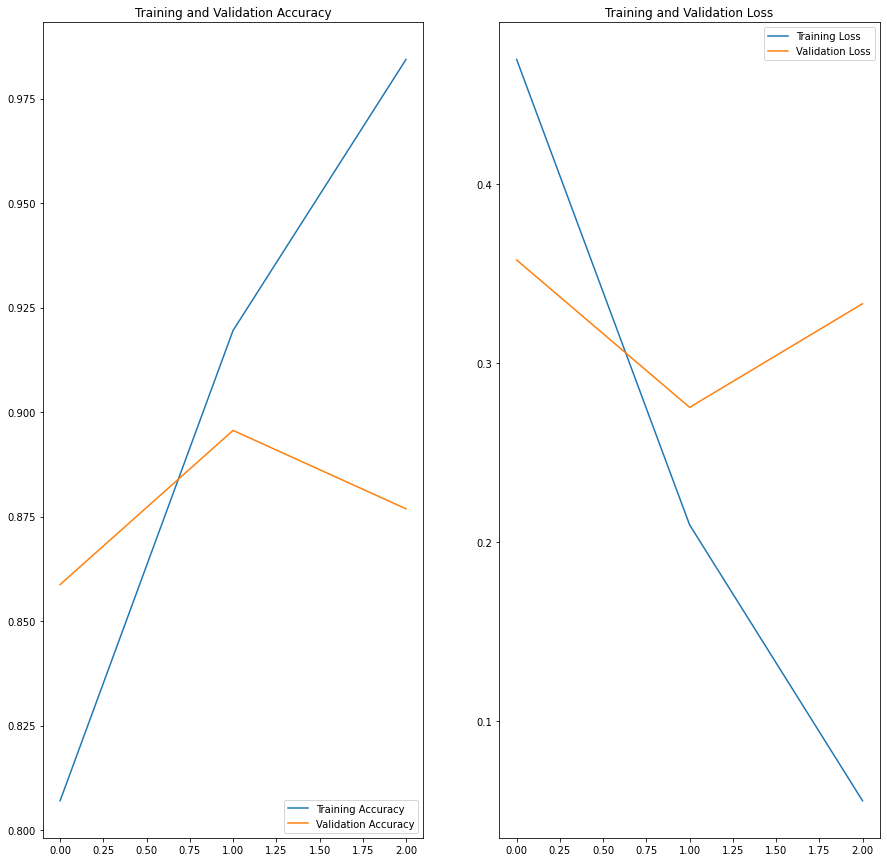

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

#epochs_range = range(22)

plt.figure(figsize=(15, 15))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
!pip install tensorflow.js

ERROR: Could not find a version that satisfies the requirement tensorflow.js (from versions: none)
ERROR: No matching distribution found for tensorflow.js
